In [103]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

ecg_csv_path = "111_ECG_timeline_20251211_194134.csv"      # ← pon aquí tu archivo ECG
events_csv_path = "111_STIM_EVENTS_20251211_194134.csv"  # ← pon aquí tu archivo de eventos

fs = 6386  # Hz


ecg = pd.read_csv(ecg_csv_path, sep=";", decimal=",", dtype={"Index": "Int64"})
ch1_val = ecg["Ch1_val_uV"].to_list()
ch2_val = ecg["Ch2_val_uV"].to_list()
time_index = np.arange(len(ch1_val)) / fs  # desde 0 hasta (len-1)/fs


# -----------------------------
# Gráfico
# -----------------------------


ch1_color = "#1f77b4"  # azul
ch2_color = "#ff7f0e"  # naranja

ch1_color = "#1f77b4"  # azul
ch1_color_stim = "#8f57b0"  # morado

ch2_color = "#ff7f0e"  # naranja
ch2_color_stim = "#007f0e"  # naranja



In [ ]:
t0_us = np.nanmin([ecg["Ch1_ts_us"].min(), ecg["Ch2_ts_us"].min()])


np.float64(1765478442120826.0)

In [114]:
events = pd.read_csv(events_csv_path, sep=";", dtype={"ch1_idx": "Int64", "ch2_idx": "Int64"})
times_stims_A = events["ch1_idx"]/fs
times_stims_B = events["ch2_idx"]/fs

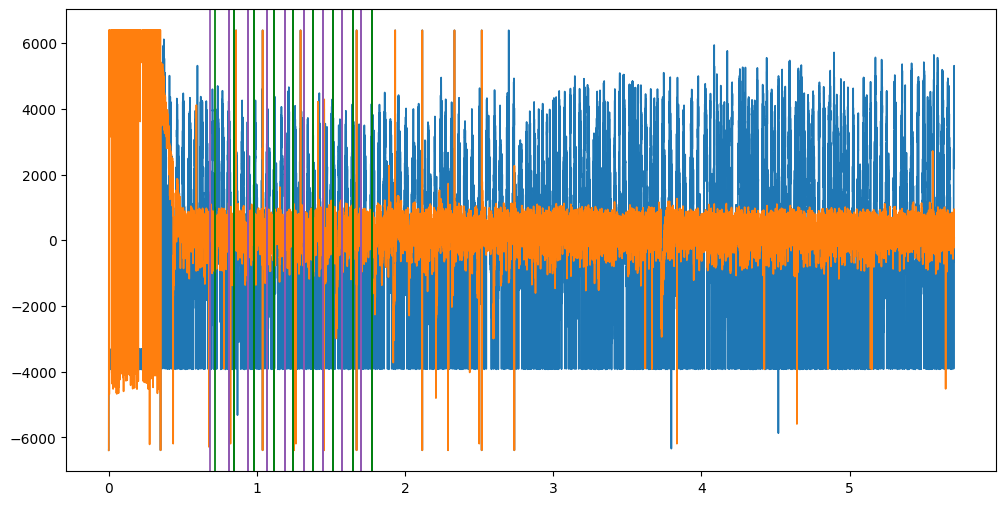

In [115]:


plt.figure(figsize=(12, 6))
ax = plt.gca()

ax.plot(time_index, ch1_val, color=ch1_color, lw=1.2, label="Ch1 (µV)")
ax.plot(time_index, ch2_val, color =ch2_color, lw=1.2, label="Ch2 (µV)")

for t in times_stims_A[1:]:
        ax.axvline(t, color=ch1_color_stim, lw=1.4, linestyle="-", alpha=0.9)

for t in times_stims_B[1:]:
        ax.axvline(t, color=ch2_color_stim, lw=1.4, linestyle="-", alpha=0.9)




In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# -----------------------------
# Configuración: rutas de archivo
# -----------------------------
ecg_csv_path = "experiment_ECG_timeline_20251211_191652.csv"      # ← pon aquí tu archivo ECG
events_csv_path = "experiment_STIM_EVENTS_20251211_191652.csv"  # ← pon aquí tu archivo de eventos

# Colores (Ch1 y Ch2) – líneas de estimulación usan el mismo color
ch1_color = "#1f77b4"  # azul
ch1_color_stim = "#8f57b0"  # morado

ch2_color = "#ff7f0e"  # naranja
ch2_color_stim = "#007f0e"  # naranja

# -----------------------------
# Carga de datos (soporta ';' y coma decimal)
# -----------------------------
# ECG: Index;Time_us;Ch1_val_uV;Ch1_ts_us;Ch2_val_uV;Ch2_ts_us;StimState
ecg = pd.read_csv(ecg_csv_path, sep=";", decimal=",", dtype={"Index": "Int64"})
# Eventos: Event;ts_us;ch1_idx;ch2_idx  (Event ∈ {ON, OFF})
events = pd.read_csv(events_csv_path, sep=";", dtype={"ch1_idx": "Int64", "ch2_idx": "Int64"})

# Convertir columnas de tiempo a numéricas (int) si no lo estuvieran
for col in ["Time_us", "Ch1_ts_us", "Ch2_ts_us"]:
    if col in ecg.columns:
        ecg[col] = pd.to_numeric(ecg[col], errors="coerce")

# Asegurar µV como float (ya hace decimal=",", pero reforzamos)
for col in ["Ch1_val_uV", "Ch2_val_uV"]:
    if col in ecg.columns:
        ecg[col] = pd.to_numeric(ecg[col], errors="coerce")

# Limpiar filas sin tiempo ni valor
ecg = ecg.dropna(subset=["Time_us"], how="all").reset_index(drop=True)

# -----------------------------
# Ejes temporales por canal (en segundos)
# Preferimos Ch1_ts_us/Ch2_ts_us; si faltan, usamos Time_us
# -----------------------------
def canal_ts_us(df, ts_col, fallback_col="Time_us"):
    if ts_col in df.columns and df[ts_col].notna().any():
        return df[ts_col]
    else:
        return df[fallback_col]

ch1_ts_us = canal_ts_us(ecg, "Ch1_ts_us")
ch2_ts_us = canal_ts_us(ecg, "Ch2_ts_us")

# Referencia temporal t0: el mínimo entre ambos canales
t0_us = np.nanmin([ch1_ts_us.min(), ch2_ts_us.min()])
t0_us = int(t0_us) if np.isfinite(t0_us) else int(ecg["Time_us"].min())

t1_sec = (ch1_ts_us - t0_us) / 1e6
t2_sec = (ch2_ts_us - t0_us) / 1e6

# -----------------------------
# Valores de los canales
# -----------------------------
ch1_val = ecg["Ch1_val_uV"] if "Ch1_val_uV" in ecg.columns else pd.Series(dtype=float)
ch2_val = ecg["Ch2_val_uV"] if "Ch2_val_uV" in ecg.columns else pd.Series(dtype=float)

# -----------------------------
# Funciones auxiliares para ubicar eventos por canal
# -----------------------------
# Mapeo Index -> ts_us por canal (si existe), sino usa Time_us
ecg_idxed = ecg.copy()
if "Index" in ecg_idxed.columns and ecg_idxed["Index"].notna().all():
    ecg_idxed = ecg_idxed.set_index("Index", drop=False)
else:
    # Si faltara Index, creamos uno secuencial (para el fallback por proximidad)
    ecg_idxed["Index"] = np.arange(len(ecg_idxed))
    ecg_idxed = ecg_idxed.set_index("Index", drop=False)

def index_to_ts_us(idx, canal="Ch1"):
    ts_col = f"{canal}_ts_us"
    if ts_col in ecg_idxed.columns and pd.notna(ecg_idxed.loc[idx, ts_col]):
        return ecg_idxed.loc[idx, ts_col]
    # Fallback: usar Time_us si el canal ts no está o es NaN
    return ecg_idxed.loc[idx, "Time_us"]

# Buscar el sample más cercano por tiempo (fallback cuando no hay idx)
def nearest_ts_us_to_sample(ts_us_target, canal="Ch1"):
    series = ch1_ts_us if canal == "Ch1" else ch2_ts_us
    # índice del más cercano
    i = np.nanargmin(np.abs(series - ts_us_target))
    return series.iloc[i]

# Extraer listas de eventos por canal (ON/OFF → tiempos en segundos)
def get_event_times(events_df, canal="Ch1"):
    idx_col = f"{canal.lower()}_idx"
    times_on_sec, times_off_sec = [], []
    for _, row in events_df.iterrows():
        evt = str(row["Event"]).strip().upper()
        ts_us_evt = pd.to_numeric(row["ts_us"], errors="coerce")

        ts_us = np.nan
        # 1) Si hay índice válido, usamos el timestamp real del sample de ese canal
        if idx_col in events_df.columns and pd.notna(row[idx_col]):
            idx = int(row[idx_col])
            if idx in ecg_idxed.index:
                ts_us = index_to_ts_us(idx, canal=canal)
        # 2) Si no hay índice, usamos ts_us del evento y lo alineamos al sample más cercano del canal
        if not np.isfinite(ts_us) and np.isfinite(ts_us_evt):
            ts_us = nearest_ts_us_to_sample(ts_us_evt, canal=canal)

        if np.isfinite(ts_us):
            t_sec = (ts_us - t0_us) / 1e6
            if evt == "ON":
                times_on_sec.append(t_sec)
            elif evt == "OFF":
                times_off_sec.append(t_sec)
    return times_on_sec, times_off_sec

ch1_on, ch1_off = get_event_times(events, canal="Ch1")
ch2_on, ch2_off = get_event_times(events, canal="Ch2")

# -----------------------------
# Gráfico
# -----------------------------
plt.figure(figsize=(12, 6))
ax = plt.gca()

# Traza de canales
if len(ch1_val) == len(t1_sec) and len(ch1_val) > 0:
    ax.plot(t1_sec, ch1_val, color=ch1_color, lw=1.2, label="Ch1 (µV)")
if len(ch2_val) == len(t2_sec) and len(ch2_val) > 0:
    ax.plot(t2_sec, ch2_val, color=ch2_color, lw=1.2, label="Ch2 (µV)")

# Líneas de estimulación (verticales)
def draw_vlines(times_on, times_off, color, label_on, label_off, ax):
    # Para que las líneas aparezcan en la leyenda, ponemos una "proxy" invisible
    if times_on:
        ax.axvline(times_on[0], color=color, lw=1.4, linestyle="-", alpha=0.9, label=label_on)
    if times_off:
        ax.axvline(times_off[0], color=color, lw=1.4, linestyle="--", alpha=0.9, label=label_off)
    # Resto de líneas (sin duplicar leyenda)
    for t in times_on[1:]:
        ax.axvline(t, color=color, lw=1.4, linestyle="-", alpha=0.9)
    for t in times_off[1:]:
        ax.axvline(t, color=color, lw=1.4, linestyle="--", alpha=0.9)

draw_vlines(ch1_on, ch1_off, ch1_color_stim, "Stim Ch1 ON", "Stim Ch1 OFF", ax)
draw_vlines(ch2_on, ch2_off, ch2_color_stim, "Stim Ch2 ON", "Stim Ch2 OFF", ax)

# Decoración
ax.set_title("ECG: Ch1 y Ch2 con instantes de estimulación por canal", fontsize=13)
ax.set_xlabel("Tiempo (s) desde el inicio", fontsize=11)
ax.set_ylabel("Amplitud (µV)", fontsize=11)
ax.grid(True, alpha=0.25)
ax.legend(loc="upper right", ncol=2, fontsize=9)
ax.set_xlim(left=0, right = 5)
# Mejorar márgenes
plt.tight_layout()

# Guardar PNG además de mostrar
out_path = Path("ecg_estim_plot.png")
plt.savefig(out_path, dpi=200)
print(f"Figura guardada en: {out_path.resolve()}")

plt.show()
